# Poem_HMM_Training

In [1]:
import os
import numpy as np
from IPython.display import HTML
import random

from HMM import unsupervised_HMM
from HMM_helper import (
    text_to_wordcloud,
    states_to_wordclouds,
    sample_sentence,
    visualize_sparsities,
    animate_emission
)

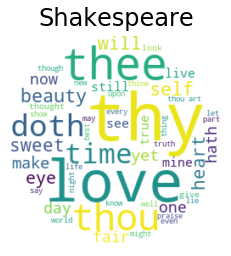

In [2]:
text = open(os.path.join(os.getcwd(), 'data/shakespeare.txt')).read()
wordcloud = text_to_wordcloud(text, title='Shakespeare')

## Helper Functions for processing the data

In [3]:
# Helper function for processing each word (Capitalization and special characters)
def parse_word(word, syllable_dict):
    word = word.lower()
    if word in syllable_dict:
        return word
    else:
        special_character_list= [',', '.', '?', '!', ';', ':', '(', ')', "'"]
        for j in range(2):
            if word[-1:] in special_character_list:
                word = word[:-1]
                if word in syllable_dict:
                    return word
            if word[:1] in special_character_list:
                word = word[1:]
                if word in syllable_dict:
                    return word
        return word
    
# Helper function for dealing with rhyme in the poems
def add_a_pair(word1, word2, rhyme_list):
    index1 = -1
    index2 = -1
    for i in range(len(rhyme_list)):
        if word1 in rhyme_list[i]:
            index1 = i
        if word2 in rhyme_list[i]:
            index2 = i
    if index1 > -1 and index2 > -1:
        rhyme_list[index1].update(rhyme_list[index2])
        rhyme_list.remove(rhyme_list[index2])
    elif index1 > -1 and index2 == -1:
        rhyme_list[index1].add(word2)
    elif index1 == -1 and index2 > -1:
        rhyme_list[index2].add(word1)
    elif index1 == -1 and index2 == -1:
        rhyme_list.append({word1, word2})    
        
def get_rhyme_dict(filename, syllable_dict):
    rhyme_dict = []
    file = open(os.path.join(os.getcwd(), filename)).read().split('\n')
    
    training_set = []
    poem = []
    for line in file:
        line_separate = line.split()
        if line_separate: 
            if len(line_separate) == 1:
                if len(poem) == 14:
                    training_set.append(poem)
                poem = []
                continue
            poem.append(line_separate)  
    
    for sonnet in training_set:
        # Following the given thyme scheme: abab-cdcd-efef-gg.
        for i in [0, 1, 4, 5, 8, 9]:
            word1 = parse_word(sonnet[i][-1], syllable_dict)
            word2 = parse_word(sonnet[i + 2][-1], syllable_dict)
            add_a_pair(word1, word2, rhyme_dict)
        # The last two terms of the rhyme in one poem
        add_a_pair(parse_word(sonnet[12][-1], syllable_dict), parse_word(sonnet[13][-1], syllable_dict), rhyme_dict)
    
    return rhyme_dict

    
# Helper function for reading the Syllable dictionary
def get_syllable_dict(filename):
    syllable_dict = {}
    file = open(os.path.join(os.getcwd(), filename)).read().split('\n')
    
    for line in file:
        if line.split():
            word_syllable = line.split()
            real_count = []
            end_count = []
            # Deal with the ending cases
            for i in range(1, len(word_syllable)):
                if word_syllable[i][0] == 'E':
                    end_count.append(int(word_syllable[i][1]))
                else:
                    real_count.append(int(word_syllable[i][0]))
            # Rank the syllable from the highest to the lowest        
            syllable_dict[word_syllable[0]] = [real_count[::-1], end_count[::-1]]

    return syllable_dict

# Helper function for getting the punctuation data
def get_punctuation_table(filename):
    
    file = open(os.path.join(os.getcwd(), filename)).read().split('\n')
    training_set = []
    poem = []
    for line in file:
        line_separate = line.split()
        if line_separate: 
            if len(line_separate) == 1:
                if len(poem) == 14:
                    training_set.append(poem)
                poem = []
                continue
            poem.append(line_separate)
    
    punc_frequency = [[0 for punctuation in range(7)] for stanza in range(4)]

    punctuation_list = [',', '.', ':', ';', '!', '?']
    odd_location1 = [0, 2, 4, 6, 8, 10] # 1st-3rd lines of 1st-3rd stanzas
    even_location2 = [1, 3, 5, 7, 9, 11] # 4th line of 1st-3rd stanzas

    for sonnet in training_set:
        for i in range(14):
            punc = sonnet[i][-1][-1]
            if punc in punctuation_list:
                punc_index = punctuation_list.index(punc)
            # No punctuation
            else:
                punc_index = 6
            if i in odd_location1:
                punc_frequency[0][punc_index] += 1
            elif i in even_location2:
                punc_frequency[1][punc_index] += 1
            elif i == 12:
                punc_frequency[2][punc_index] += 1
            elif i == 13:
                punc_frequency[3][punc_index] += 1
    
    return punc_frequency
    
# Helper function: imported from the template "HMM_helper.py" with little revision
def parse_observations(text, syllable_dict):
    # Convert text to dataset.
    lines = [line.split() for line in text.split('\n') if line.split()]
    
    obs_counter = 0
    obs = []
    obs_map = {}

    for line in lines:
        if len(line) == 1:
            continue
        
        # Reverse the line for rhyme training
        line.reverse()
        obs_elem = []
    
        for word in line:
            if word not in syllable_dict:
                word1 = parse_word(word, syllable_dict)
            else:
                word1 = word
            
            if word1 not in obs_map:
                # Add unique words to the observations map.
                obs_map[word1] = obs_counter
                obs_counter += 1
            
            # Add the encoded word.
            obs_elem.append(obs_map[word1])
        
        # Add the encoded sequence.
        obs.append(obs_elem)

    return obs, obs_map

## Data preprocessing (with helper functions)

In [4]:
# Reading the file
filename = 'data/shakespeare.txt'
syllable_name = 'data/Syllable_dictionary.txt'
Shakes_poem = open(os.path.join(os.getcwd(), filename)).read()

# Extracting observation and syllable_dict
syllable_dict = get_syllable_dict(syllable_name)
obs, obs_map = parse_observations(Shakes_poem, syllable_dict)

# Get the reversed word_map
word_map = {}
for key in obs_map:
    word_map[obs_map[key]] = key
rhyme_dict = get_rhyme_dict(filename, syllable_dict)
punctuation_list = get_punctuation_table(filename)

# Get the CMU NLTK dictionary
import nltk
stress_list = nltk.corpus.cmudict.entries()
stress_dict = {}
for word, breakdown in stress_list:
    unprocessed = []
    if word in stress_dict:
        stress_dict.get(word).append(breakdown)
    else:
        unprocessed.append(breakdown)
        stress_dict[word] = unprocessed

## Helper Functions for generating sentences and punctuations

In [5]:
# Generate a sentence without rhyme
def sentence_without_rhyme(hmm, word_map, M_syllable = 10):
    emission, states = hmm.generate_emission(M_syllable, word_map, syllable_dict)
    sentence = [word_map[i] for i in emission][::-1]
    sentence[0] = sentence[0].capitalize()
    return ' '.join(sentence)

# Generate a sentence with a given word at the end (helper function for rhyme generator)
def sentence_with_given_end(hmm, given_word, M_syllable = 10):
    # Choose a state that could have generated the word
    given_state = hmm.find_state(obs_map[given_word])
    
    # Sample and reverse the sentence
    emission, states = hmm.generate_emission_rhyme_stress(given_word, given_state, M_syllable, word_map, obs_map, 
                                                          syllable_dict, stress_dict)
    sentence = [word_map[i] for i in emission][::-1]
    sentence[0] = sentence[0].capitalize()
    return ' '.join(sentence)

# Generate sentence pairs with rhyme
def sentences_pair_with_rhyme(hmm, rhyme_dict, M_syllable = 10, N_sentences = 2):
    # Choose a rhyming group with enough words
    rhyme_group = []
    for group in rhyme_dict:
        if len(group) >= N_sentences:
            rhyme_group.append(group)

    # Choose a group of rhyme word
    chosen_group = random.choice(rhyme_group)
    words = random.sample(chosen_group, N_sentences)
    
    sentence_pair = []
    for word in words:
        sentence_pair.append(sentence_with_given_end(hmm, word, M_syllable))
        
    return sentence_pair

# Punctuation generator
def punc_generator(location):
    punctuation_choice = [',', '.', ':', ';', '!', '?']
    chosen_index = random.choices(range(len(punctuation_list[location])), weights=punctuation_list[location])[0]
    if chosen_index == 6:
        return ''
    else:
        return punctuation_choice[chosen_index]

## Helper functions for generating entire sonnet

In [6]:
# Generate a sonnet without rhyme and stress
def generate_sonnet(hmm, word_map, M_syllable = 10):
    poem = ''
    for i in range(12):
        if i % 2 == 0:
            poem += sentence_without_rhyme(hmm, word_map, M_syllable) + punc_generator(0) + '\n'
        else:
            poem += sentence_without_rhyme(hmm, word_map, M_syllable) + punc_generator(1) + '\n'
    # Last stanza
    poem += '  ' + sentence_without_rhyme(hmm, word_map, M_syllable) + punc_generator(2) + '\n  '
    poem += sentence_without_rhyme(hmm, word_map, M_syllable) + punc_generator(3) + '\n'
    print(poem)    
    
    
# Generate a sonnet in Shakespeare's style (with rhyme and stress)
def generate_sonnet_rhyme_stress(hmm, rhyme_dict):
    poem = ''
    # The first three stanzas (abab)
    for stanza in range(3):
        l1, l3 = sentences_pair_with_rhyme(hmm, rhyme_dict)
        l2, l4 = sentences_pair_with_rhyme(hmm, rhyme_dict)
        poem += (l1 + punc_generator(0) + '\n' + l2 + punc_generator(1) + '\n' + 
                l3 + punc_generator(0) + '\n' + l4 + punc_generator(1) + '\n' + '\n')
        
    # last stanza (gg)
    l5, l6 = sentences_pair_with_rhyme(hmm, rhyme_dict)
    poem += '  ' + l5 + punc_generator(2) + '\n  ' + l6 + punc_generator(3) + '\n' 
    print(poem)

# Generate a Haiku sonnet (3 sentences, syllables: 5 + 7 + 5)      
def generate_sonnet_haikus(hmm, word_map):
    print(sentence_without_rhyme(hmm, word_map, M_syllable = 5))
    print(sentence_without_rhyme(hmm, word_map, M_syllable = 7))
    print(sentence_without_rhyme(hmm, word_map, M_syllable = 5))

# Generate a petrachan sonnet (14 sentences, each with 10 syllables, rhyme: abbaabba, cdcdcd)    
def generate_sonnet_petrarchan(hmm, rhyme_dict):
    poem = ''
    
    a = sentences_pair_with_rhyme(hmm, rhyme_dict, M_syllable = 10, N_sentences = 4)
    b = sentences_pair_with_rhyme(hmm, rhyme_dict, M_syllable = 10, N_sentences = 4)
    c = sentences_pair_with_rhyme(hmm, rhyme_dict, M_syllable = 10, N_sentences = 3)
    d = sentences_pair_with_rhyme(hmm, rhyme_dict, M_syllable = 10, N_sentences = 3)

    poem += (a[0] + '\n' + b[0] + '\n' + b[1] + '\n' + a[1] + '\n' +a[2] + '\n' + b[2] + '\n' + b[3] + '\n' + a[3] + '\n'
             + '\n' + c[0] + '\n' + d[0] + '\n' + c[1] + '\n' + d[1] + '\n' + c[2] + '\n' + d[2] + '\n')
    
    print(poem)
    
# Generate a limerick sonnet (5 sentences, each with a , rhyme: aabba)    
def generate_sonnet_limerick(hmm, rhyme_dict):
    poem = ''
    
    a = sentences_pair_with_rhyme(hmm, rhyme_dict, M_syllable = random.randint(7, 10), N_sentences = 3)
    b = sentences_pair_with_rhyme(hmm, rhyme_dict, M_syllable = random.randint(5, 7), N_sentences = 2)
    
    poem += (a[0] + '\n' + a[1] + '\n' + b[0] + '\n' + b[1] + '\n' + a[2] + '\n')
    print(poem)

## Training the HMM models, Generate poems and Visualization

### HMM with 16 hidden states

In [7]:
hmm16 = unsupervised_HMM(obs, 16, 100)

0
Iteration: 0
1
2
3
4
5
Iteration: 5
6
7
8
9
10
Iteration: 10
11
12
13
14
15
Iteration: 15
16
17
18
19
20
Iteration: 20
21
22
23
24
25
Iteration: 25
26
27
28
29
30
Iteration: 30
31
32
33
34
35
Iteration: 35
36
37
38
39
40
Iteration: 40
41
42
43
44
45
Iteration: 45
46
47
48
49
50
Iteration: 50
51
52
53
54
55
Iteration: 55
56
57
58
59
60
Iteration: 60
61
62
63
64
65
Iteration: 65
66
67
68
69
70
Iteration: 70
71
72
73
74
75
Iteration: 75
76
77
78
79
80
Iteration: 80
81
82
83
84
85
Iteration: 85
86
87
88
89
90
Iteration: 90
91
92
93
94
95
Iteration: 95
96
97
98
99


In [8]:
generate_sonnet(hmm16, word_map, M_syllable = 10)

Thy him than anchored of more to fair love's,
Outward tender i took pearl dearths art but,
Star removed addition offence's checked,
Hast thou self he's like as eyes my that chide,
Thy copy thou replete with that him i'll,
The millioned fault greater scope away will seen
Shall me me thy nearly heart can the change
Cheeks earth they will the reap nor therefore like?
Own most bears were slave riches to my place,
Make but book even might love ever my sport:
He gives world that continual will with me,
Enforced nor he proving is the am what.
  To my conquest self-willed me and my blind,
  Are her and nothing noted just all with.



In [9]:
generate_sonnet_rhyme_stress(hmm16, rhyme_dict)

Given the perfect'st time well-seeing that bower,
Birth wand'rest in importune more stol'n kiss;
Millioned look plods whate'er my power by power,
Many lie over-goes my being false many this,

Slavery love o'ersways fair warrantise hearts,
Were't flame beauty's for sweet'st sin beauty's stained.
Spites that covetous to blessed deserts,
Beweep love's tillage of beseechers reigned?

Quietus holds beauty's and trouble should fulness,
Whate'er thou honour in whether that were't muse.
Blessed such wretch woman's wakened their dulness,
Given mine being breast even my usurer use,

  Whether not withering loved ill-wresting afloat,
  I couldst and where-through be beseechers boat.



In [10]:
generate_sonnet_haikus(hmm16, word_map)

Bonds in dear revenge
Have are at may sweets even and
Thy suns and sealed mine


In [11]:
generate_sonnet_petrarchan(hmm16, rhyme_dict)

Marriage shallowest lasting offence's twain
In deformed'st of outworn lines beauteous waste
Unwooed my shamefully even i lov'st haste
Being antiquity self-willed thy heaven's main
Be vassalage thy world-without-end pain
Self-loving delight given fickle canst past
Even men seest skill beweep may resty last
Shall o'er-snowed if well-seeing their heaven gain

Those o'er hours lov'st love beauty's achieve
Hour basest they desire fair sightless thing
To lov'st if ill-used unwooed that 'gainst give
Shouldst the erst with being name over-goes sing
Many love never-resting love tongue-tied live
Bliss whereto guard beauty's offences spring



In [12]:
generate_sonnet_limerick(hmm16, rhyme_dict)

Sickle's all ever-fixed wooed even none
Delight beauty's me even hold basest one
Influence for freezings is
That tired of heaven amiss
Like whereon heavy desire so given stone



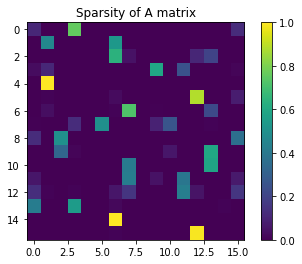

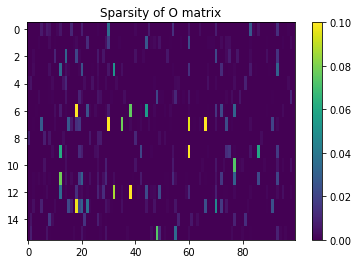

In [13]:
visualize_sparsities(hmm16, O_max_cols=100)

### HMM with 32 hidden states

In [14]:
hmm32 = unsupervised_HMM(obs, 32, 100)

0
Iteration: 0
1
2
3
4
5
Iteration: 5
6
7
8
9
10
Iteration: 10
11
12
13
14
15
Iteration: 15
16
17
18
19
20
Iteration: 20
21
22
23
24
25
Iteration: 25
26
27
28
29
30
Iteration: 30
31
32
33
34
35
Iteration: 35
36
37
38
39
40
Iteration: 40
41
42
43
44
45
Iteration: 45
46
47
48
49
50
Iteration: 50
51
52
53
54
55
Iteration: 55
56
57
58
59
60
Iteration: 60
61
62
63
64
65
Iteration: 65
66
67
68
69
70
Iteration: 70
71
72
73
74
75
Iteration: 75
76
77
78
79
80
Iteration: 80
81
82
83
84
85
Iteration: 85
86
87
88
89
90
Iteration: 90
91
92
93
94
95
Iteration: 95
96
97
98
99


In [16]:
generate_sonnet(hmm32, word_map, M_syllable = 10)

I my things that kill to within me pen
Doth cease who so grind of her verse seek thy.
Then praise look shall hands from my love him are,
Seem as and nothing it if show new in,
Sweet thou and no mouths a toil which but if,
But of love how thou in doth it now green,
Most art these why sick all thee for thy fair,
Sides thus small enfeebled will ay her tongue.
In my i it change and or that to thy,
In drunk for find of my sweet but canst a.
Soil of be hue bettered of the beauty,
To men in every bloody that of sun,
  Self self renew longer so the sorrow,
  Truth hymns in not with influence give me.



In [17]:
generate_sonnet_rhyme_stress(hmm32, rhyme_dict)

All unthrift that chopt now impiety,
Spites springs given robs spites style vouchsafe so swearing,
He usurer and hear'st society,
Being weed were't thy power and wouldst conquered bearing.

Flowers that beseem compound wherewith respect
Bloody saith from poesy dignified.
Inhearse you receiv'st with virtuous suspect,
Task highmost even o'er my beauty's dyed:

Shouldst shall sourly please whether flowers mayst left
Spirit it votary for shamefully hits,
Truth's in merchandized side makeless bereft,
Stol'n babe three-fold from even and attaint fits,

  That desiring no aught own sportive burn,
  Sourly behold th' those th' at shouldst overturn.



In [18]:
generate_sonnet_haikus(hmm32, word_map)

Base featured stands we
Not proceeds place from weeds but
Brain nor i doth to


In [19]:
generate_sonnet_petrarchan(hmm32, rhyme_dict)

Beseechers flowers desiring abide
Unthrift said youngly that shallowest esteem
Reeleth get many's own throned redeem
Burthens thee slander's waiting powerful slide
Was limbecks most effectually belied
Rud'st i is't forfeit towers hast glutton seem
Being that flowers thee engraft long attaint deem
Honour what used thee importune wide

Seest it o'er-green and dear-purchased expense
Steep-up gracious spites fond churl do th' love 'greeing
Whate'er receiving deserv'st excellence
Be dear-purchased journey sourly their seeing
Possesseth praising bristly difference
Live freezings the flowers from shallowest fly being



In [20]:
generate_sonnet_limerick(hmm32, rhyme_dict)

Preposterously two given me o'er might
Heart lov'st a spirit i heaven's might aright
Blessed-fair th' counting flowers jaws
Whether when erst thy powerful paws
Mayst not sweet-seasoned gored th' send being sight



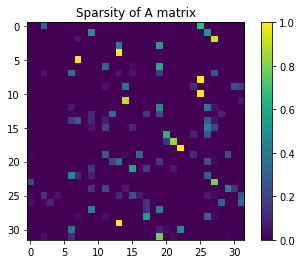

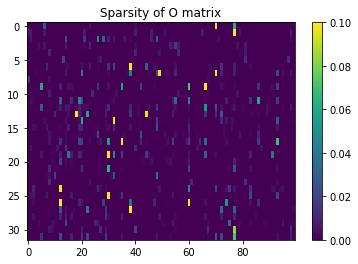

In [21]:
visualize_sparsities(hmm32, O_max_cols=100)